<a href="https://colab.research.google.com/github/U1186204/Explainable-Deep-Learning/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries for Computer Vision and GradCAM Evaluation

In [1]:
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
import kagglehub
import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import plotly.express as px
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

from keras.callbacks import EarlyStopping as ES, ModelCheckpoint as MC

from tensorflow.keras.applications import ResNet50V2, ResNet50, InceptionV3, Xception

### Loading Dataset


*LINK to Kaggle dataset below*

[![Kaggle Dataset](https://img.shields.io/badge/Kaggle-Microorganism_Image_Classification-blue.svg?logo=kaggle&style=for-the-badge)](https://www.kaggle.com/datasets/mdwaquarazam/microorganism-image-classification/data)

In [2]:
path = kagglehub.dataset_download("mdwaquarazam/microorganism-image-classification")
print(f"Path to dataset files: {path}")

subfolder_name = os.listdir(path)[0]
data_dir = os.path.join(path, subfolder_name)

classes_names = sorted(os.listdir(data_dir))
n_classes = len(classes_names)

class_distribution = {name: len(os.listdir(os.path.join(data_dir, name))) for name in classes_names}

print(f"Number of classes: {n_classes} \nClass Names: {classes_names}")

100%|██████████| 101M/101M [00:00<00:00, 172MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mdwaquarazam/microorganism-image-classification/versions/6
Number of classes: 8 
Class Names: ['Amoeba', 'Euglena', 'Hydra', 'Paramecium', 'Rod_bacteria', 'Spherical_bacteria', 'Spiral_bacteria', 'Yeast']


### Exploratory Data Analysis

In [3]:
total_images = sum(class_distribution.values())


text_labels = [f'{(value / total_images) * 100:.2f}%' for value in class_distribution.values()]

fig = px.bar(
    x=classes_names,
    # Make Y a %
    y=[(value / total_images) * 100 for value in class_distribution.values()],
    text=text_labels,
    title="Microorganism Class Distribution"
)

fig.update_traces(textposition='outside')

fig.update_layout({'title': {'x':0.5}})

fig.show()

### EDA Interpretation
- It appears the number of obervations for each lass is unevenly distirbuted in the dataset.
- some classes appear to have more data(Euglena & Paramecium) while some have less(Hydra and Amoeba)

### Data Pre-Processing

In [4]:
gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    horizontal_flip=True,
    brightness_range=[0.3, 0.8],
    validation_split=0.1
)

### Defining Training & Validation Sets

In [5]:
train_df = gen.flow_from_directory(
    data_dir,
    batch_size=128,
    shuffle=True,
    class_mode='sparse',
    target_size=(256,256),
    subset='training'
)

val_df = gen.flow_from_directory(
    data_dir,
    batch_size=64,
    shuffle=True,
    class_mode='sparse',
    target_size=(256,256),
    subset='validation'
)

Found 714 images belonging to 8 classes.
Found 75 images belonging to 8 classes.


### Function to Visulaize Images

In [6]:
def visualize_images(data, GRID=[2,6], model=None, size=(25,10)):

    n_row, n_col = GRID
    n_images = n_row * n_col
    plt.figure(figsize = size)

    images,labels = next(iter(data))

    for i in range(1, n_images + 1):

        id = np.random.randint(len(images))

        image, label = images[id], classes_names[int(labels[id])]

        plt.subplot(n_row,n_col, i)
        plt.imshow(image)
        plt.axis('off')


        if model is not None:
            pred = classes_names[np.argmax(model.predict(image[np.newaxis,...]))]
            title = f"Class: {label}\nPred: {pred}"

        else:
            title = f"Class: {label}"

        plt.title(title)
    plt.show()

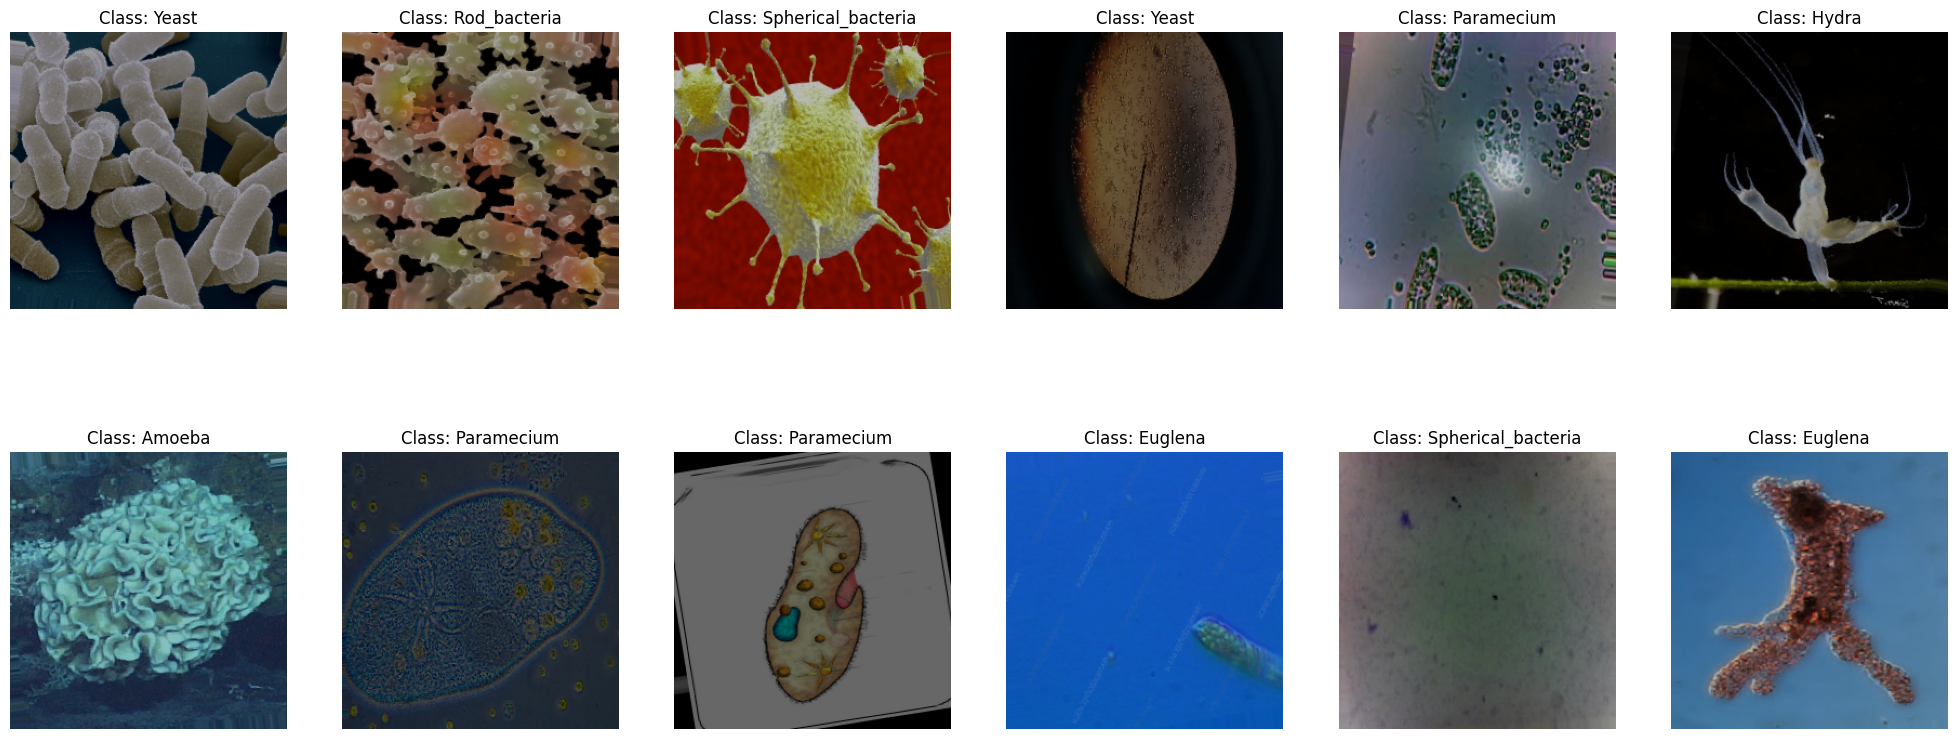

In [7]:
visualize_images(data=train_df, model=None)

# Implementing Inception-v3-Model (NO GradCAM Yet)

In [8]:
name = "inception-v3"

base = InceptionV3(input_shape=(256,256,3), include_top=False, weights='imagenet')
base.trainable = False

inputs = tf.keras.Input(shape=(256, 256, 3))
x = base(inputs, training=False)
x = GAP()(x)
x = Dense(256, kernel_initializer='he_normal', activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(n_classes, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

callbacks = [ES(patience=3, restore_best_weights=True), MC(name + '.h5', save_best_only=True)]

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss ='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

history = model.fit(train_df, validation_data=val_df, epochs=50, callbacks=callbacks)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1710 - loss: 2.6411

6/6 ━━━━━━━━━━━━━━━━━━━━ 81s 11s/step - accuracy: 0.1798 - loss: 2.6136 - val_accuracy: 0.3467 - val_loss: 1.9487
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3905 - loss: 1.7386

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.3971 - loss: 1.7224 - val_accuracy: 0.5200 - val_loss: 1.4614
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5553 - loss: 1.3924

6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.5564 - loss: 1.3867 - val_accuracy: 0.5600 - val_loss: 1.2731
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6060 - loss: 1.1752

6/6 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.6065 - loss: 1.1708 - val_accuracy: 0.6933 - val_loss: 1.0428
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.6929 - loss: 0.9734 - val_accuracy: 0.6267 - val_loss: 1.0574
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6590 - loss: 0.9574

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.6649 - loss: 0.9469 - val_accuracy: 0.6933 - val_loss: 0.9592
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7313 - loss: 0.8394 - val_accuracy: 0.6933 - val_loss: 0.9983
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.7420 - loss: 0.8053 - val_accuracy: 0.6800 - val_loss: 0.9712
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7821 - loss: 0.6850

6/6 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - accuracy: 0.7818 - loss: 0.6837 - val_accuracy: 0.6933 - val_loss: 0.9132
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.7889 - loss: 0.6131 - val_accuracy: 0.6800 - val_loss: 0.9238
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step - accuracy: 0.8104 - loss: 0.5963 - val_accuracy: 0.7067 - val_loss: 0.9408
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - accuracy: 0.8259 - loss: 0.5481 - val_accuracy: 0.6667 - val_loss: 0.9709


### Initial Prediciton vs Actual Class Comparison

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


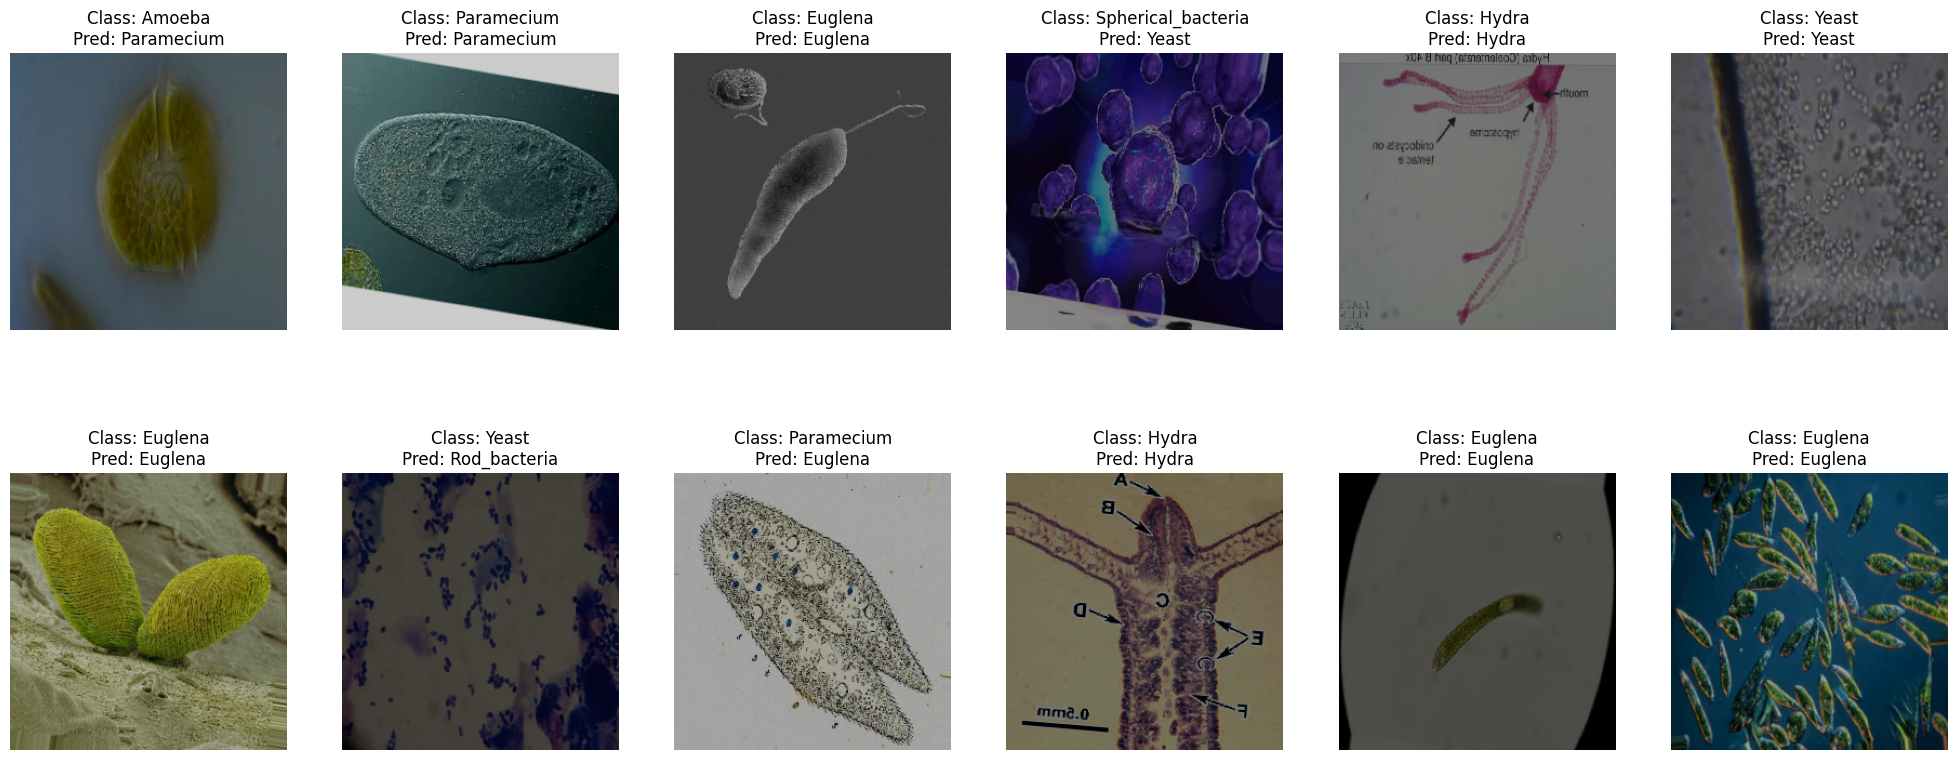

In [9]:
visualize_images(data = val_df, model=model)

In [16]:
def generate_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # This is the final, most robust implementation that bypasses the Keras bug.

    # Create a simple feature extractor model that outputs the last conv layer's activations
    # Get the input tensor from the original model's input layer
    input_layer = model.get_layer('inception_v3').input
    last_conv_layer = model.get_layer('inception_v3').get_layer(last_conv_layer_name)
    feature_extractor = tf.keras.Model(inputs=input_layer, outputs=last_conv_layer.output)

    # Use GradientTape to compute the gradient of the predicted class
    with tf.GradientTape() as tape:
        # Get the feature map for the input image
        features = feature_extractor(img_array)
        # We must "watch" this tensor for the gradient calculation to work
        tape.watch(features)

        # Manually apply the classifier layers to the features to get the final prediction
        # The classifier head starts after the base model (index 1, which is the GAP layer)
        x = features
        # Find the index of the GlobalAveragePooling2D layer
        gap_layer_index = None
        for i, layer in enumerate(model.layers):
            if isinstance(layer, GAP):
                gap_layer_index = i
                break

        if gap_layer_index is not None:
            for i in range(gap_layer_index, len(model.layers)): # Start from the GAP layer
                x = model.layers[i](x)
            preds = x # This is now the final prediction tensor
        else:
             # Fallback if GAP layer is not found (shouldn't happen with the current model)
             preds = model(img_array, training=False)


        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron with respect to the output feature map
    grads = tape.gradient(class_channel, features)

    # Pool the gradients and weight the feature map channels
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    features = features[0]
    heatmap = features @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap for visualization
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()

### Implementing GradCAM into Model

Using target layer: mixed10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


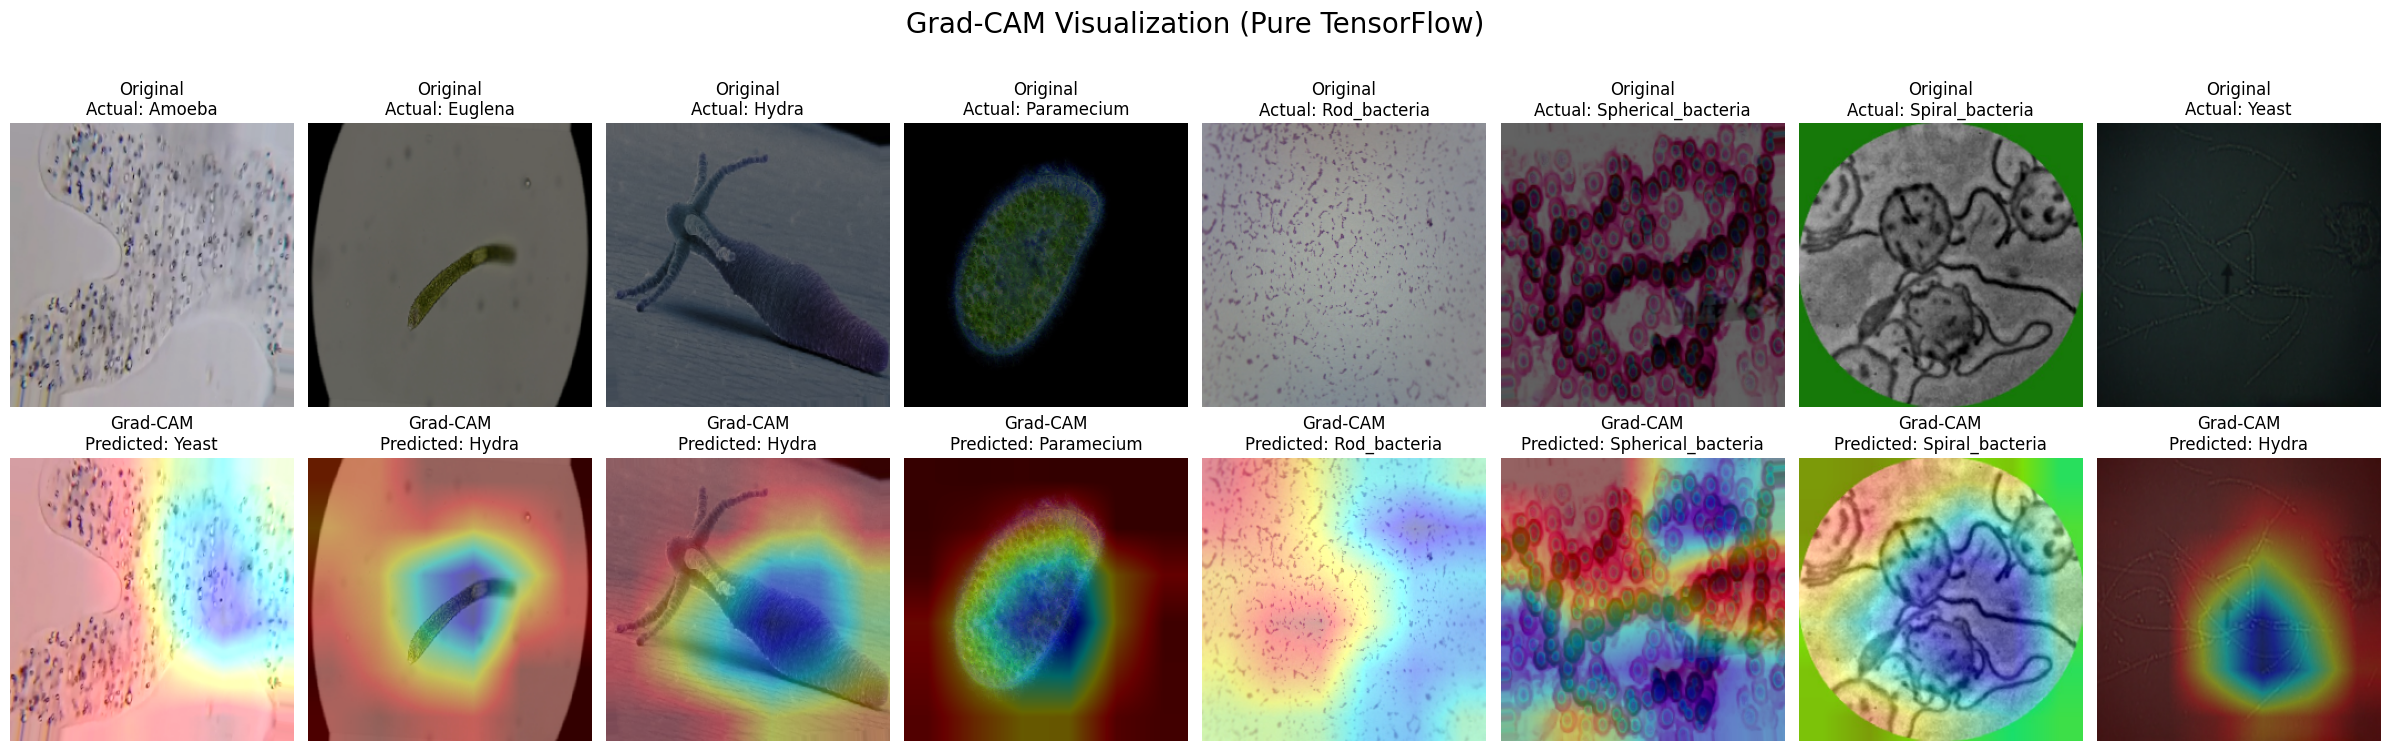

In [17]:
# Find the base model and the last conv layer by name
base_model = model.get_layer('inception_v3')
last_conv_layer_name = base_model.layers[-1].name
print(f"Using target layer: {last_conv_layer_name}")

# Get one image per class for visualization
images_by_class = {}
while len(images_by_class) < n_classes:
    images, labels = next(val_df)
    for img, label in zip(images, labels):
        label_index = int(label)
        if label_index not in images_by_class:
            images_by_class[label_index] = img
        if len(images_by_class) == n_classes:
            break

sorted_items = sorted(images_by_class.items())
sample_images = np.array([item[1] for item in sorted_items])
sample_labels = np.array([item[0] for item in sorted_items])
preds = model.predict(sample_images)
pred_indices = np.argmax(preds, axis=1)

# Visualization Code
plt.figure(figsize=(24, 8))
for i in range(8):
    img = sample_images[i]
    img_array = np.expand_dims(img, axis=0)

    # Call the function
    heatmap = generate_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=pred_indices[i])

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * 0.4 + np.uint8(255 * img)
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)

    actual_class = classes_names[int(sample_labels[i])]
    predicted_class = classes_names[pred_indices[i]]

    plt.subplot(2, 8, i + 1)
    plt.imshow(img)
    plt.title(f"Original\nActual: {actual_class}")
    plt.axis('off')

    plt.subplot(2, 8, i + 8 + 1)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM\nPredicted: {predicted_class}")
    plt.axis('off')

plt.suptitle("Grad-CAM Visualization (Pure TensorFlow)", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Implementing GradCAM - with Variant 1 into Model

### Implementing GradCAM with Variant 2 into Model